Inputted image:


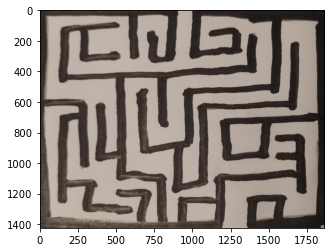

Solved Maze!


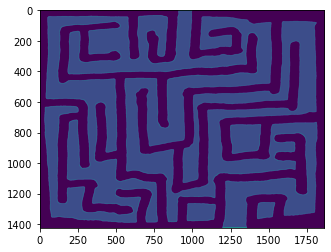

In [129]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import random 

# === RULES FOR MAZE IMAGE: ===
# Outer border of image must be the walls, and it must be a dark colour
# The start of the maze must be in the top row, and the end in the bottom. 
# The start and end of the maze must be empty spaces in the top and bottom rows.


# ==== Defining functions: =====

def load_in_image(filename, pixel_params):
    '''Takes a raw image file of a maze, and returns a cleaned-up version.'''
    # Load in image:
    maze_colour = mpimg.imread(filename)
    # Show the inputted image, to make sure it's what you want:
    print("Inputted image:")
    maze_colour_plot = plt.imshow(maze_colour) 
    plt.show()
    
    pixel_threshold, empty_space_val, wall_val, image_is_hand_drawn = pixel_params
    
    # Gaussian smoothing:
    if image_is_hand_drawn:
        maze_colour = ndimage.gaussian_filter(maze_colour, sigma=(5, 5, 0), order=0)
       
    # Notes about working with a maze image in a .jpg format:
    # In color, [0, 0, 0] is black, [255, 255, 255] is white. 
    # Due to resolution I assume, there is some blurring around the lines of the maze (e.g. [35, 35, 35])
    # Will convert images to grayscale by taking the "grayscale pixel value" to be the average of the R, G, 
    # and B pixel values in the original image. For a black and white image, this shouldn't be too different
    # from just using the first index, but may as well try to future proof for colour images.
    maze_gray = np.zeros([maze_colour.shape[0], maze_colour.shape[1]])
    for i in range(0, maze_gray.shape[0]):
        for j in range(0, maze_gray.shape[1]):
            maze_gray[i,j] = (int(maze_colour[i,j,0]) + int(maze_colour[i,j,1]) + int(maze_colour[i,j,2])) // 3
    
    # Create a clean version of the maze with only black and white:
    maze_clean = np.zeros(maze_gray.shape)
    for i in range(0, maze_clean.shape[0]):
        for j in range(0, maze_clean.shape[1]):
            if maze_gray[i,j] > pixel_threshold:
                maze_clean[i,j] = empty_space_val # this is empty space
            else:
                maze_clean[i,j] = wall_val # this is a wall
    mpimg.imsave("AfterGaussianSmoothButBeforeRemovingSpikes.bmp", maze_clean)
    
    # A little more pre-processing: turn any pixels that are surrounded on three sides by walls into walls too.
    for i in range(1, maze_clean.shape[0] - 1):
        for j in range(1, maze_clean.shape[1] - 1):
            if maze_clean[i,j] == empty_space_val:
                if int(maze_clean[i,j-1] == wall_val) + int(maze_clean[i,j+1] == wall_val) + int(maze_clean[i-1,j] == wall_val) + int(maze_clean[i+1,j] == wall_val) >= 3:
                    maze_clean[i,j] = wall_val
    return maze_clean


def cut_out_central_pixels(clean_maze, empty_pix_val, extra_empty_pix_val):
    ''' Takes as input a clean maze (i.e. all pixels are definitely either wall or empty).
    Returns a maze where all pixels that do not border a wall have been coloured, leaving only
    pixels bordering walls.'''
    esv = empty_pix_val
    pixel_flip_tracker = np.zeros(np.shape(clean_maze))

    for i in range(2, clean_maze.shape[0] - 2):
        for j in range(1, clean_maze.shape[1] - 2):
            if clean_maze[i,j] == esv: # check if current pixel is empty
                if (clean_maze[i-1,j] == esv) and (clean_maze[i+1,j] == esv): #check if bordering empty above and below
                    if (clean_maze[i,j-1] == esv) and (clean_maze[i,j+1] == esv): # check if bordering empty left and right
                        # Check diagonals too:
                        if (clean_maze[i-1,j-1] == esv) and (clean_maze[i-1,j+1] == esv) and (clean_maze[i+1,j-1] == esv) and (clean_maze[i+1,j+1] == esv):
                        # if entirely surrounded by empty spaces to two pixels, we can cut it out.
                            pixel_flip_tracker[i,j] = 1
    
    # Colour in any unnecessary pixels
    simple_maze = clean_maze
    
    for i in range(0, clean_maze.shape[0]):
        for j in range(0, clean_maze.shape[1]):
            if pixel_flip_tracker[i,j]:
                simple_maze[i,j] = extra_empty_pix_val
    return simple_maze
    
def find_start_point(simplified_maze, empty_space_val, wall_to_hug='R'):
    if wall_to_hug == 'R':
        for i in range(0, np.shape(simplified_maze)[1]):
            if simplified_maze[0, i] == empty_space_val: 
                pixel_to_start_on = i
                break
    else:
        for i in range(np.shape(simplified_maze)[1] - 1, 0, -1):
            if simplified_maze[0, i] == empty_space_val: 
                pixel_to_start_on = i
                break
    return pixel_to_start_on

def get_steps_from_dir(direc):
    if direc == 'D':
        try_row_step = 1
        try_col_step = 0   
    elif direc == 'R':
        try_row_step = 0
        try_col_step = 1
    elif direc == 'L':
        try_row_step = 0
        try_col_step = -1
    elif direc == 'U':
        try_row_step = -1
        try_col_step = 0
    else:
        return None
    return (try_row_step, try_col_step)

def find_next_step(working_maze, current_row, current_col, order_of_dirs, prev_direction, empty_space_val):
    
    current_dir_index = order_of_dirs.index(prev_direction)
    
    while True: # keep trying until you have a direction that gets you where you need to be
        if random.randint(0, 100) == 10:
            mpimg.imsave("WorkingMaze.bmp", working_maze)
        try_row_step, try_col_step = get_steps_from_dir(order_of_dirs[current_dir_index])
        if working_maze[current_row + try_row_step, current_col + try_col_step] == empty_space_val:
            next_row = current_row + try_row_step
            next_col = current_col + try_col_step
            return (next_row, next_col)
        elif working_maze[current_row + try_row_step, current_col + try_col_step] != empty_space_val:
            current_dir_index = (current_dir_index + 1) % 4
        
        
        
        
        
# ==== Defining constants/parameters/filenames: ====

# Directory and filename for maze:
filename_base = r'C:\Users\nickg\Desktop\Side Projects\Test images\\' # Need a double backslash here to work properly with the apostrophe
maze_filename = 'Hand-Drawn Maze.jpg' 
image_is_hand_drawn = True # Hand-drawn or digital?
# maze_filename = 'Hand-Drawn Maze.jpg'

# Defining where maze starts/ends:
start_side = 'top' # options are 'top', 'bottom', 'right', 'left'
end_side = 'bottom' # options are 'top', 'bottom', 'right', 'left'

# Defining strategy:
wall_to_hug = 'L' # options are 'R', 'L'. Default to R
if wall_to_hug == 'R':
    order_of_dirs = ['R', 'U', 'L', 'D']
elif wall_to_hug == 'L':
    order_of_dirs = ['R', 'D', 'L', 'U']
    
# For preparing a "clean" maze:
pixel_threshold = 140 # any pixel in the raw grayscale maze with a value below this is a wall, and above this is a space
empty_space_val = 255 # in the sanitized maze, set any "empty" pixel to this
wall_val = 0 # in the sanitized maze, set any wall pixel to this
extra_empty_pix_val = 60 # the value to which all of the "extra" empty pixels (that do not hug walls) will be set
path_pix_value = 200 # the value to which pixels in the path will be set
pixel_params = [pixel_threshold, empty_space_val, wall_val, image_is_hand_drawn] # prepare a list of parameters to pass to the function


# ===== Main Program: ======
if __name__ == "__main__":
    # Load in the image, and generate a clean version of the maze from it.
    clean_maze = load_in_image(filename_base + maze_filename, pixel_params)
    mpimg.imsave('CleanMaze.bmp', clean_maze)
    
    num_rows = np.shape(clean_maze)[0]
    num_cols = np.shape(clean_maze)[1]
    
    # Colour in any empty pixels that ONLY border other empty pixels
    simplified_maze = cut_out_central_pixels(clean_maze, empty_space_val, extra_empty_pix_val)
    mpimg.imsave("SimpleMaze.bmp", simplified_maze)
    
    working_maze = simplified_maze
    
    # Find starting pixel:
    if start_side == 'top':
        start_pix_col = find_start_point(simplified_maze, empty_space_val, wall_to_hug)
        working_maze[0, start_pix_col] = path_pix_value
#         mpimg.imsave("WorkingMaze.bmp", working_maze)
    
        # Calculate where we should end up:
        end_row = np.shape(working_maze)

        # Keeping track of what row and column we are currently in.
        current_row = 0
        current_col = start_pix_col
        prev_direction = 'D'

        while current_row < num_rows - 1:            
            # Find next pixel in path:
            try:
                next_row, next_col = find_next_step(working_maze, current_row, current_col, order_of_dirs, prev_direction, empty_space_val)
            except TypeError:
                break
            # Prepare for next iteration:
            working_maze[next_row, next_col] = path_pix_value # add to path
            current_row, current_col = next_row, next_col
            
        print('Solved Maze!')
        solved_maze = working_maze
        mpimg.imsave("SolvedMaze.bmp", solved_maze)
        solved_maze_plot = plt.imshow(solved_maze) 
        plt.show()

Inputted image:


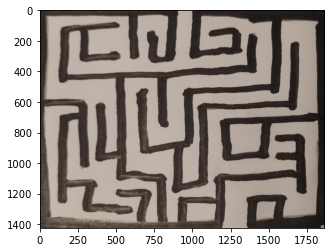

Solved Maze!


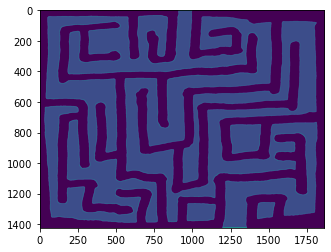

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import random 

# === RULES FOR MAZE IMAGE: ===
# Outer border of image must be the walls, and it must be a dark colour
# The start of the maze must be in the top row, and the end in the bottom. 
# The start and end of the maze must be empty spaces in the top and bottom rows.


# ==== Defining functions: =====

def load_in_image(filename, pixel_params):
    '''Takes a raw image file of a maze, and returns a cleaned-up version.'''
    # Load in image:
    maze_colour = mpimg.imread(filename)
    # Show the inputted image, to make sure it's what you want:
    print("Inputted image:")
    maze_colour_plot = plt.imshow(maze_colour) 
    plt.show()
    
    pixel_threshold, empty_space_val, wall_val, image_is_hand_drawn = pixel_params
    
    # Gaussian smoothing:
    if image_is_hand_drawn:
        maze_colour = ndimage.gaussian_filter(maze_colour, sigma=(5, 5, 0), order=0)
       
    # Notes about working with a maze image in a .jpg format:
    # In color, [0, 0, 0] is black, [255, 255, 255] is white. 
    # Due to resolution I assume, there is some blurring around the lines of the maze (e.g. [35, 35, 35])
    # Will convert images to grayscale by taking the "grayscale pixel value" to be the average of the R, G, 
    # and B pixel values in the original image. For a black and white image, this shouldn't be too different
    # from just using the first index, but may as well try to future proof for colour images.
    maze_gray = np.zeros([maze_colour.shape[0], maze_colour.shape[1]])
    for i in range(0, maze_gray.shape[0]):
        for j in range(0, maze_gray.shape[1]):
            maze_gray[i,j] = (int(maze_colour[i,j,0]) + int(maze_colour[i,j,1]) + int(maze_colour[i,j,2])) // 3
    
    # Create a clean version of the maze with only black and white:
    maze_clean = np.zeros(maze_gray.shape)
    for i in range(0, maze_clean.shape[0]):
        for j in range(0, maze_clean.shape[1]):
            if maze_gray[i,j] > pixel_threshold:
                maze_clean[i,j] = empty_space_val # this is empty space
            else:
                maze_clean[i,j] = wall_val # this is a wall
    mpimg.imsave("AfterGaussianSmoothButBeforeRemovingSpikes.bmp", maze_clean)
    
    # A little more pre-processing: turn any pixels that are surrounded on three sides by walls into walls too.
    for i in range(1, maze_clean.shape[0] - 1):
        for j in range(1, maze_clean.shape[1] - 1):
            if maze_clean[i,j] == empty_space_val:
                if int(maze_clean[i,j-1] == wall_val) + int(maze_clean[i,j+1] == wall_val) + int(maze_clean[i-1,j] == wall_val) + int(maze_clean[i+1,j] == wall_val) >= 3:
                    maze_clean[i,j] = wall_val
    return maze_clean


def cut_out_central_pixels(clean_maze, empty_pix_val, extra_empty_pix_val):
    ''' Takes as input a clean maze (i.e. all pixels are definitely either wall or empty).
    Returns a maze where all pixels that do not border a wall have been coloured, leaving only
    pixels bordering walls.'''
    esv = empty_pix_val
    pixel_flip_tracker = np.zeros(np.shape(clean_maze))

    for i in range(2, clean_maze.shape[0] - 2):
        for j in range(1, clean_maze.shape[1] - 2):
            if clean_maze[i,j] == esv: # check if current pixel is empty
                if (clean_maze[i-1,j] == esv) and (clean_maze[i+1,j] == esv): #check if bordering empty above and below
                    if (clean_maze[i,j-1] == esv) and (clean_maze[i,j+1] == esv): # check if bordering empty left and right
                        # Check diagonals too:
                        if (clean_maze[i-1,j-1] == esv) and (clean_maze[i-1,j+1] == esv) and (clean_maze[i+1,j-1] == esv) and (clean_maze[i+1,j+1] == esv):
                        # if entirely surrounded by empty spaces to two pixels, we can cut it out.
                            pixel_flip_tracker[i,j] = 1
    
    # Colour in any unnecessary pixels
    simple_maze = clean_maze
    
    for i in range(0, clean_maze.shape[0]):
        for j in range(0, clean_maze.shape[1]):
            if pixel_flip_tracker[i,j]:
                simple_maze[i,j] = extra_empty_pix_val
    return simple_maze
    
def find_start_point(simplified_maze, empty_space_val, wall_to_hug='R'):
    if wall_to_hug == 'R':
        for i in range(0, np.shape(simplified_maze)[1]):
            if simplified_maze[0, i] == empty_space_val: 
                pixel_to_start_on = i
                break
    else:
        for i in range(np.shape(simplified_maze)[1] - 1, 0, -1):
            if simplified_maze[0, i] == empty_space_val: 
                pixel_to_start_on = i
                break
    return pixel_to_start_on

def get_steps_from_dir(direc):
    if direc == 'D':
        try_row_step = 1
        try_col_step = 0   
    elif direc == 'R':
        try_row_step = 0
        try_col_step = 1
    elif direc == 'L':
        try_row_step = 0
        try_col_step = -1
    elif direc == 'U':
        try_row_step = -1
        try_col_step = 0
    else:
        return None
    return (try_row_step, try_col_step)

def find_next_step(working_maze, current_row, current_col, order_of_dirs, prev_direction, empty_space_val):
    
    current_dir_index = order_of_dirs.index(prev_direction)
    
    while True: # keep trying until you have a direction that gets you where you need to be
#         if random.randint(0, 100) == 10:
#             mpimg.imsave("WorkingMaze.bmp", working_maze)
        try_row_step, try_col_step = get_steps_from_dir(order_of_dirs[current_dir_index])
        if working_maze[current_row + try_row_step, current_col + try_col_step] == empty_space_val:
            next_row = current_row + try_row_step
            next_col = current_col + try_col_step
            return (next_row, next_col)
        elif working_maze[current_row + try_row_step, current_col + try_col_step] != empty_space_val:
            current_dir_index = (current_dir_index + 1) % 4
        
        
        
        
        
# ==== Defining constants/parameters/filenames: ====

# Directory and filename for maze:
filename_base = r'C:\Users\nickg\Desktop\Side Projects\Test images\\' # Need a double backslash here to work properly with the apostrophe
maze_filename = 'Hand-Drawn Maze.jpg' 
image_is_hand_drawn = True # Hand-drawn or digital?
# maze_filename = 'Hand-Drawn Maze.jpg'

# Defining where maze starts/ends:
start_side = 'top' # options are 'top', 'bottom', 'right', 'left'
end_side = 'bottom' # options are 'top', 'bottom', 'right', 'left'

# Defining strategy:
wall_to_hug = 'L' # options are 'R', 'L'. Default to R
if wall_to_hug == 'R':
    order_of_dirs = ['R', 'U', 'L', 'D']
elif wall_to_hug == 'L':
    order_of_dirs = ['R', 'D', 'L', 'U']
    
# For preparing a "clean" maze:
pixel_threshold = 140 # any pixel in the raw grayscale maze with a value below this is a wall, and above this is a space
empty_space_val = 255 # in the sanitized maze, set any "empty" pixel to this
wall_val = 0 # in the sanitized maze, set any wall pixel to this
extra_empty_pix_val = 60 # the value to which all of the "extra" empty pixels (that do not hug walls) will be set
path_pix_value = 200 # the value to which pixels in the path will be set
pixel_params = [pixel_threshold, empty_space_val, wall_val, image_is_hand_drawn] # prepare a list of parameters to pass to the function


# ===== Main Program: ======
if __name__ == "__main__":
    # Load in the image, and generate a clean version of the maze from it.
    clean_maze = load_in_image(filename_base + maze_filename, pixel_params)
    mpimg.imsave('CleanMaze.bmp', clean_maze)
    
    num_rows = np.shape(clean_maze)[0]
    num_cols = np.shape(clean_maze)[1]
    
    # Colour in any empty pixels that ONLY border other empty pixels
    simplified_maze = cut_out_central_pixels(clean_maze, empty_space_val, extra_empty_pix_val)
    mpimg.imsave("SimpleMaze.bmp", simplified_maze)
    
    working_maze = simplified_maze # the maze that will be modified as the path is calculated
    
    # Find starting pixel:
    if (start_side == 'top') and (end_side == 'bottom'):
        start_pix_col = find_start_point(simplified_maze, empty_space_val, wall_to_hug)
        working_maze[0, start_pix_col] = path_pix_value
#         mpimg.imsave("WorkingMaze.bmp", working_maze)
    
        # Calculate where we should end up:
        end_row = np.shape(working_maze)

        # Keeping track of what row and column we are currently in.
        current_row = 0
        current_col = start_pix_col
        prev_direction = 'D'

        while current_row < num_rows - 1:            
            # Find next pixel in path:
            try:
                next_row, next_col = find_next_step(working_maze, current_row, current_col, order_of_dirs, prev_direction, empty_space_val)
            except TypeError:
                break
            # Prepare for next iteration:
            working_maze[next_row, next_col] = path_pix_value # add to path
            current_row, current_col = next_row, next_col
        
    print('Solved Maze!')
    solved_maze = working_maze
    mpimg.imsave("SolvedMaze.bmp", solved_maze)
    solved_maze_plot = plt.imshow(solved_maze) 
    plt.show()